## Part 1: The James-Stein Estimator (20 P)

Let $x_1,\dots,x_N \in \mathbb{R}^d$ be independent draws from a multivariate Gaussian distribution with mean vector $\mu$ and covariance matrix $\Sigma = \sigma^2 I$. It can be shown that the maximum-likelihood estimator of the mean parameter $\mu$ is the empirical mean given by:
$$
\hat \mu_\text{ML} = \frac1N \sum_{i=1}^N x_i
$$
Maximum-likelihood appears to be a strong estimator. However, it was demonstrated that the following estimator
$$
\hat \mu_{JS} = \Big(1-\frac{(d-2) \cdot \frac{\sigma^2}{N}}{\|\hat{\mu}_\text{ML}\|^2}\Big) \hat{\mu}_\text{ML}
$$
(a shrinked version of the maximum-likelihood estimator towards the origin) has actually a smaller distance from the true mean when $d \geq 3$. This however assumes knowledge of the variance of the distribution for which the mean is estimated. This estimator is called the James-Stein estimator. While the proof is a bit involved, this fact can be easily demonstrated empirically through simulation. This is the object of this exercise.

The code below draws ten 50-dimensional points from a normal distribution with mean vector $\mu = (1,\dots,1)$ and covariance $\Sigma = I$.

In [1]:
import numpy

def getdata(seed):

    n = 10              # data points
    d = 50              # dimensionality of data
    m = numpy.ones([d]) # true mean
    s = 1.0             # true standard deviation

    rstate = numpy.random.mtrand.RandomState(seed)
    X = rstate.normal(0,1,[n,d])*s+m
    
    return X,m,s



The following function computes the maximum likelihood estimator from a sample of the data assumed to be generated by a Gaussian distribution:

In [2]:
def ML(X):
    return X.mean(axis=0)

### Implementing the James-Stein Estimator (10 P)

* **Based on the ML estimator function, write a function that receives as input the data $(X_i)_{i=1}^n$ and the (known) variance $\sigma^2$ of the generating distribution, and computes the James-Stein estimator**

In [3]:
def JS(X,s):
    
    m_js=ML(X)*(1-((len(X[0])-2)/(len(X)*numpy.linalg.norm(ML(X))**2)))
        
    return m_js

### Comparing the ML and James-Stein Estimators (10 P)

We would like to compute the error of the maximum likelihood estimator and the James-Stein estimator for 100 different samples (where each sample consists of 10 draws generated by the function `getdata` with a different random seed). Here, for reproducibility, we use seeds from 0 to 99. The error should be measured as the Euclidean distance between the true mean vector and the estimated mean vector.

* **Compute the maximum-likelihood and James-Stein estimations.**
* **Measure the error of these estimations.**
* **Build a scatter plot comparing these errors for different samples.**

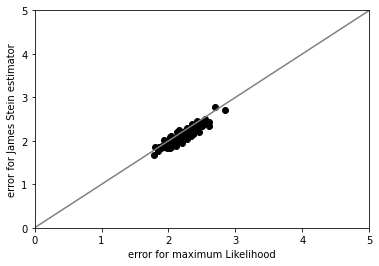

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial import distance
error_m=[]
error_js=[]
for i in range(100):
    error_m.append(distance.euclidean(ML(getdata(i)[0]),getdata(i)[1]))
    error_js.append(distance.euclidean(getdata(i)[1],JS(getdata(i)[0],1.0)))

plt.scatter(error_m,error_js,c='black')
plt.plot(range(6),range(6),c='grey')
plt.xlim(0,5)
plt.ylim(0,5)
plt.xlabel("error for maximum Likelihood")
plt.ylabel("error for James Stein estimator")
plt.show()




## Part 2: Bias/Variance Decomposition (30 P)

In this part, we would like to implement a procedure to find the bias and variance of different predictors. We consider one for regression and one for classification. These predictors are available in the module utils.

* **`utils.ParzenRegressor`:** A regression method based on Parzen window. The hyperparameter corresponds to the scale of the Parzen window. A large scale creates a more rigid model. A small scale creates a more flexible one.

* **`utils.ParzenClassifier`:** A classification method based on Parzen window. The hyperparameter corresponds to the scale of the Parzen window. A large scale creates a more rigid model. A small scale creates a more flexible one. Note that instead of returning a single class for a given data point, it outputs a probability distribution over the set of possible classes.

Each class of predictor implements the following three methods:

  - **`__init__(self,parameter):`** Create an instance of the predictor with a certain scale parameter.

  - **`fit(self,X,T):`** Fit the predictor to the data (a set of data points `X` and targets `T`).
    
  - **`predict(self,X):`** Compute the output values arbitrary inputs `X`.
  
  
To compute the bias and variance estimates, we require *multiple samples* from the training set for a single set of observation data. To acomplish this, we utilize the **`Sampler`** class provided. The sampler is initialized with the training data and passed to the method for estimating bias and variance, where its function **`sampler.sample()`** is called repeatedly in order to fit multiple models and create an ensemble of prediction for each test data point.

### Regression Case (15 P)

For the regression case, Bias, Variance and Error are given by:

 * $\mathrm{Bias}(Y)^2 = (\mathbb{E}_Y [ Y - T ])^2$
 * $\mathrm{Var}(Y)$ $= \mathbb{E}_Y [(Y - \mathbb{E}_Y[Y])^2 ]$
 * $\mathrm{Error}(Y)$ = $\mathbb{E}_Y[(Y-T)^2]$
 
**Task:** Implement the KL-based Bias-Variance Decomposition defined above. The function should repeatedly sample training sets from the sampler (as many times as specified by the argument nbsamples), learn the predictor on them, and evaluate the variance on the out-of-sample distribution given by X and T.

In [5]:

def biasVarianceRegression(sampler, predictor, X, T, nbsamples=25):
    
    bias=[]
    err=[]
    variance=err
    for i in range(nbsamples):
        sx,sT=sampler.sample()
        predictor.fit(sx,sT)
        pre=predictor.predict(X)
        bias.append(pre-T)
        err.append((pre-T)**2)
        #variance.append(err-bias**2)
    
    return bias,variance




Your implementation can be tested with the following code:

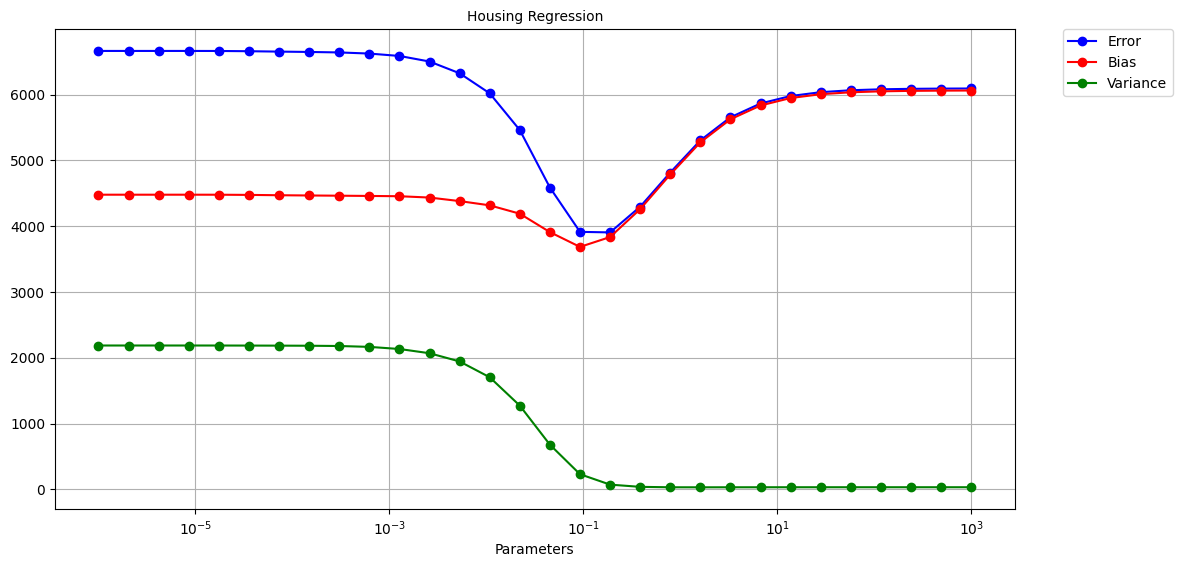

In [6]:
import utils,numpy
%matplotlib inline
utils.plotBVE(utils.Diabetes,numpy.logspace(-6,3,num=30),utils.ParzenRegressor,biasVarianceRegression,'Diabetes Regression')

### Classification Case (15 P)

We consider here the Kullback-Leibler divergence as a measure of classification error, as derived in the exercise, the Bias, Variance decomposition for such error is:

- $\mathrm{Bias}(Y) = D_\mathrm{KL}(T||R)$

- $\mathrm{Var}(Y) = \mathbb{E}_Y[D_\mathrm{KL}(R||Y)]$

- $\mathrm{Error}(Y) = \mathbb{E}_Y[D_\mathrm{KL}(T||Y)]$

where $R$ is the distribution that minimizes its expected KL divergence from the estimator of probability distribution $Y$ (see the theoretical exercise for how it is computed exactly), and where $T$ is the target class distribution.

**Task:** Implement the KL-based Bias-Variance Decomposition defined above. The function should repeatedly sample training sets from the sampler (as many times as specified by the argument nbsamples), learn the predictor on them, and evaluate the variance on the out-of-sample distribution given by X and T.

In [7]:
def biasVarianceClassification(sampler, predictor, X, T, nbsamples=25):
    
 
    return bias,variance

Your implementation can be tested with the following code:

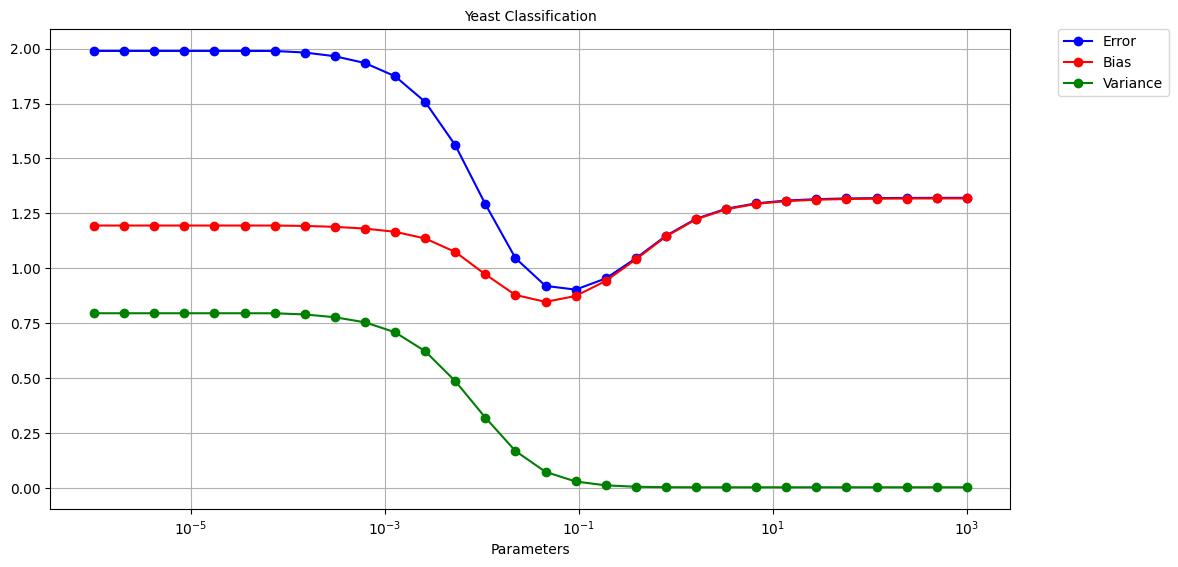

In [8]:
import utils,numpy
%matplotlib inline
utils.plotBVE(utils.Yeast,numpy.logspace(-6,3,num=30),utils.ParzenClassifier,biasVarianceClassification,'Yeast Classification')